# Libraries

In [1]:
from cdasws import CdasWs
import pandas as pd
import numpy as np
from spacepy import pycdf
import matplotlib as plt
from dtw import *
cdas = CdasWs()
plt.rcParams["figure.figsize"] = [20, 10]

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Step 1 - Loading Datasets: DSCOVER, WIND, WIND SWE

In [2]:
vars_wind = ['BF1','BGSM','BGSE']
time = ['2022-08-25T21:58:45.000Z', '2022-08-25T23:58:45.000Z']
#time = ['2022-09-10T22:58:59.000Z', '2022-09-17T22:59:59.000Z']
status_wind, data_wind = cdas.get_data('WI_H2_MFI', vars_wind, time[0], time[1])

In [3]:
vars_dscovr = ['B1F1','B1SDF1','B1GSE','B1SDGSE','B1RTN','B1SDRTN']
dscovr_values = 'BF1','BGSM','BGSE'
#time = ['2022-09-17T21:59:59.000Z', '2022-09-17T23:59:59.000Z']
status_dscovr, data_dscovr = cdas.get_data('DSCOVR_H0_MAG', vars_dscovr, time[0], time[1])

In [4]:
vars_wind_swe = ['fit_flag','year','doy','Proton_V_nonlin','Proton_V_nonlin_errorbars','Proton_sigmaV_nonlin','Proton_VX_nonlin','Proton_VX_nonlin_errorbars','Proton_sigmaVX_nonlin','Proton_VY_nonlin','Proton_VY_nonlin_errorbars','Proton_sigmaVY_nonlin','Proton_VZ_nonlin','Proton_VZ_nonlin_errorbars','Proton_sigmaVZ_nonlin','Proton_W_nonlin','Proton_W_nonlin_errorbars','Proton_sigmaW_nonlin','Proton_Wperp_nonlin','Proton_Wperp_nonlin_errorbars','Proton_sigmaWperp_nonlin','Proton_Wpar_nonlin','Proton_Wpar_nonlin_errorbars','Proton_sigmaWpar_nonlin','EW_flowangle','EW_flowangle_errorbars','SigmaEW_flowangle','NS_flowangle','NS_flowangle_errorbars','SigmaNS_flowangle','Proton_Np_nonlin','Proton_Np_nonlin_log','Proton_Np_nonlin_errorbars','Proton_sigmaNp_nonlin','Alpha_V_nonlin','Alpha_V_nonlin_errorbars','Alpha_sigmaV_nonlin','Alpha_VX_nonlin','Alpha_VX_nonlin_errorbars','Alpha_sigmaVX_nonlin','Alpha_VY_nonlin','Alpha_VY_nonlin_errorbars','Alpha_sigmaVY_nonlin','Alpha_VZ_nonlin','Alpha_VZ_nonlin_errorbars','Alpha_sigmaVZ_nonlin','Alpha_W_nonlin','Alpha_W_nonlin_errorbars','Alpha_sigmaW_nonlin','Alpha_Wperp_nonlin','Alpha_Wperp_nonlin_errorbars','Alpha_sigmaWperp_nonlin','Alpha_Wpar_nonlin','Alpha_Wpar_nonlin_errorbars','Alpha_sigmaWpar_nonlin','Alpha_Na_nonlin','Alpha_Na_nonlin_log','Alpha_Na_nonlin_errorbars','Alpha_sigmaNa_nonlin','ChisQ_DOF_nonlin','Peak_doy','sigmaPeak_doy','Proton_V_moment','Proton_VX_moment','Proton_VY_moment','Proton_VZ_moment','Proton_W_moment','Proton_Wperp_moment','Proton_Wpar_moment','Proton_Np_moment','Proton_Np_moment_log','BX','BY','BZ','Ang_dev','dev','xgse','ygse','zgse','ygsm','zgsm']
#time = ['2022-08-25T21:58:45.000Z', '2022-08-25T23:58:45.000Z']
status, data_wind_swe = cdas.get_data('WI_H1_SWE', vars_wind_swe, time[0], time[1]) 

In [16]:
wind_swe_values = 'Proton_V_moment','Proton_W_moment','Proton_Np_moment','Epoch'
wind_swe = pd.DataFrame.from_dict(data_wind_swe[wind_swe_values])
wind_swe['Epoch'] = pd.to_datetime(wind_swe.Epoch)
wind_swe.set_index('Epoch', inplace = True)

wind_values = 'BF1','Epoch'
wind = pd.DataFrame.from_dict(data_wind[wind_values])
wind['Epoch'] = pd.to_datetime(wind.Epoch)
wind.set_index('Epoch', inplace = True)

dscovr_values = 'B1F1','Epoch1'
dscovr = pd.DataFrame.from_dict(data_dscovr[dscovr_values])
dscovr['Epoch1'] = pd.to_datetime(dscovr.Epoch1)
dscovr.set_index('Epoch1', inplace = True)
#dscovr.replace(-1.000000e+31, dscovr['B1F1'].median(), inplace=True)
dscovr.loc[dscovr['B1F1'] == -1.000000e+31, 'B1F1'] = dscovr.loc[dscovr['B1F1'] != -1.000000e+31].median()
dscovr.dropna(inplace=True)

In [17]:
print(wind_swe.reset_index().shape)
print(wind.reset_index().shape)
print(dscovr.reset_index().shape)

(57, 4)
(75946, 2)
(7183, 2)


<AxesSubplot: xlabel='Epoch'>

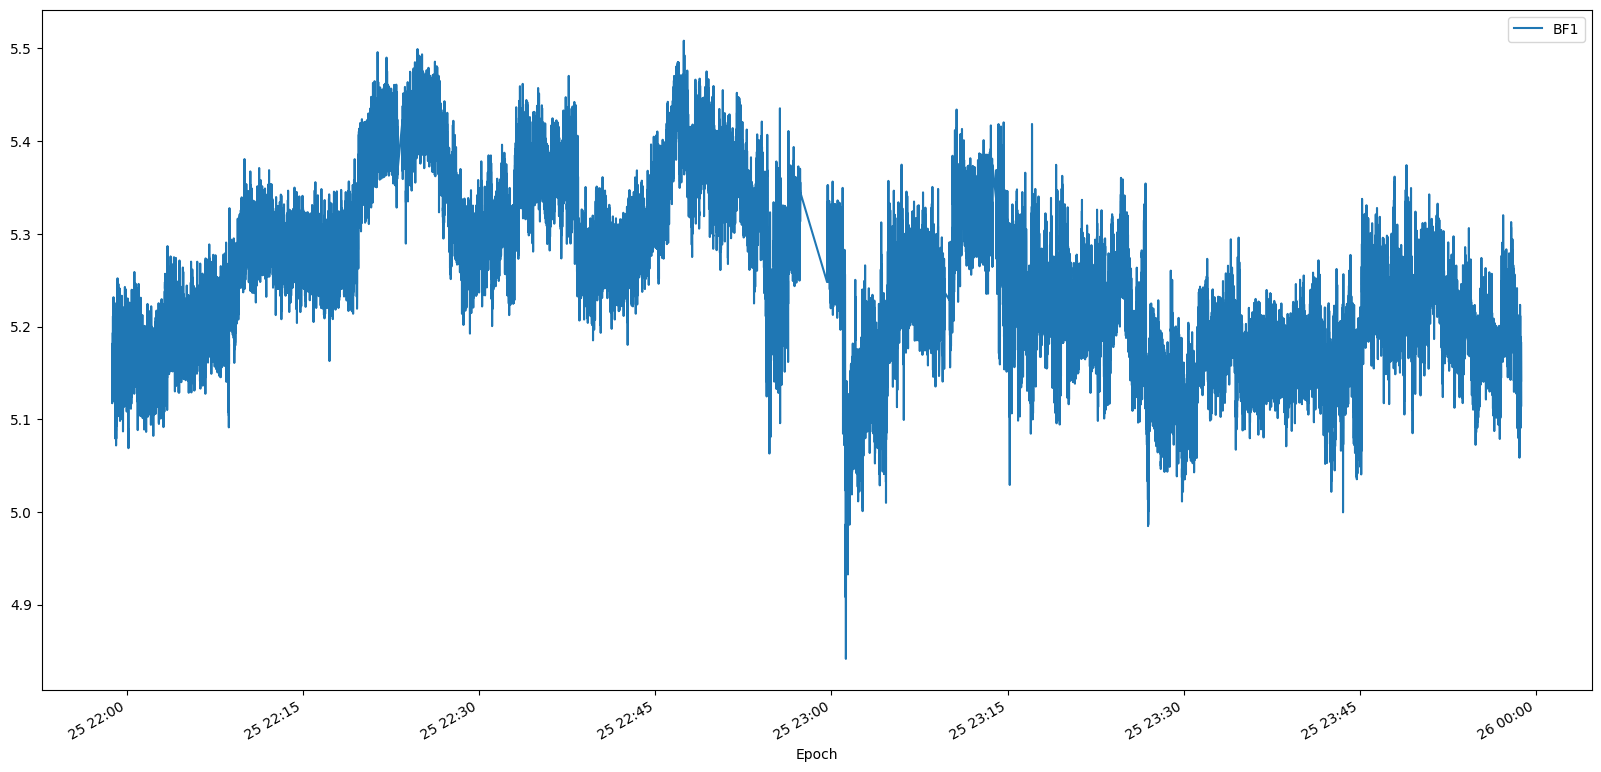

In [19]:
wind.plot()

<AxesSubplot: xlabel='Epoch1'>

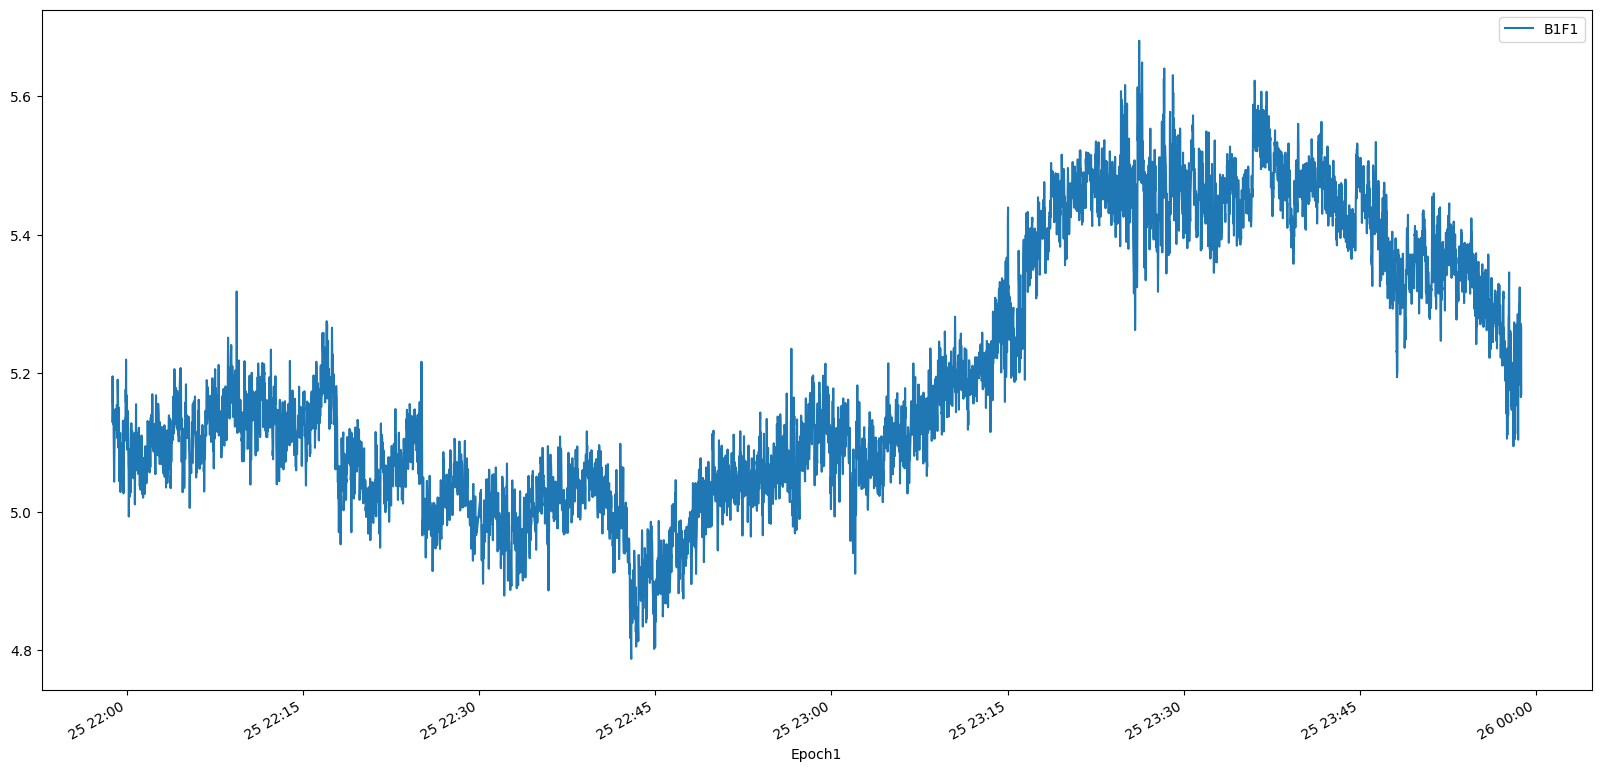

In [20]:
dscovr.plot()

# Step 2 - Dynamic Time Warping DSCOVR - WIND Unifying dataset

In [21]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [22]:
distance, path = fastdtw(dscovr, wind, dist=euclidean)

In [147]:
def union_dtw(y,path):
    lista1 = []
    lista2 = []
    n = len(path)
    for j in range(n):
        lista1.append(path[j][0])
    for j in range(n):
        lista2.append(path[j][1])

    lista1 = pd.DataFrame(lista1,columns=['valor'])
    lista1['valor1'] = lista2
    #lista2 = pd.DataFrame(lista2,columns=['valor'])
    #lista1['ind'] = lista1.index
    lista1 = lista1.groupby('valor').agg(minimo=('valor1','min'),maximo=('valor1','max')).reset_index()
    lista1['val'] = ''
    for j in range(lista1.shape[0]):
        lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
    
    return lista1,lista2


In [148]:
lista1,lista2  = union_dtw(wind,path)

/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_7706/3960654097.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_7706/3960654097.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_7706/3960654097.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [149]:
lista1

,valor,minimo,maximo,val
0,0,0,0,5.136906
1,1,0,0,5.136906
2,2,0,0,5.136906
3,3,0,0,5.136906
4,4,0,0,5.136906
...,...,...,...,...
7178,7178,75938,75938,5.158048
7179,7179,75939,75939,5.141355
7180,7180,75940,75943,5.141644
7181,7181,75944,75944,5.13216


In [137]:
path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 3),
 (15, 4),
 (16, 5),
 (17, 6),
 (18, 7),
 (18, 8),
 (19, 9),
 (20, 9),
 (21, 9),
 (22, 9),
 (23, 9),
 (24, 10),
 (24, 11),
 (24, 12),
 (24, 13),
 (24, 14),
 (24, 15),
 (24, 16),
 (24, 17),
 (24, 18),
 (24, 19),
 (24, 20),
 (24, 21),
 (24, 22),
 (24, 23),
 (24, 24),
 (24, 25),
 (24, 26),
 (24, 27),
 (24, 28),
 (24, 29),
 (24, 30),
 (24, 31),
 (24, 32),
 (24, 33),
 (24, 34),
 (24, 35),
 (24, 36),
 (24, 37),
 (24, 38),
 (25, 39),
 (26, 40),
 (26, 41),
 (26, 42),
 (26, 43),
 (26, 44),
 (26, 45),
 (26, 46),
 (26, 47),
 (26, 48),
 (26, 49),
 (26, 50),
 (26, 51),
 (26, 52),
 (26, 53),
 (26, 54),
 (26, 55),
 (26, 56),
 (26, 57),
 (26, 58),
 (26, 59),
 (27, 60),
 (28, 61),
 (28, 62),
 (29, 63),
 (29, 64),
 (29, 65),
 (29, 66),
 (29, 67),
 (29, 68),
 (29, 69),
 (29, 70),
 (29, 71),
 (29, 72),
 (29, 73),
 (29, 74),
 (29, 75),
 (29, 76),
 (29, 77),
 (

In [104]:
wind.reset_index().iloc[0:2].BF1

0    5.136906
1    5.135727
Name: BF1, dtype: float32

In [87]:
lista1

,valor,ind
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
80179,7180,80179
80180,7180,80180
80181,7180,80181
80182,7181,80182


In [ ]:
#alignment = dtw(dscovr['2022-09-17 22:30:59.000':'2022-09-17 23:25:59.000'], wind['2022-09-17 22:15:59.000':'2022-09-17 22:20:59.000'])#, keep_internals=True)
alignment = dtw(dscovr, wind, keep_internals=True)


In [ ]:
alignment.plot(type="twoway",offset=-0.5)

In [ ]:
dtw(dscovr['2022-09-17 22:30:59.000':'2022-09-17 23:25:59.000'], wind['2022-09-17 22:15:59.000':'2022-09-17 22:20:59.000'], keep_internals=True, window_type="sakoechiba", window_args={'window_size':2},
    step_pattern='symmetricP1').plot(type="twoway",offset=-2)
plt.show()

In [ ]:
alignment = dtw(wind, y=dscovr, dist_method='euclidean', step_pattern='symmetric2', window_type=None, window_args={}, keep_internals=True, distance_only=False, open_end=False, open_begin=False)

In [ ]:
dtw( wind,dscovr, keep_internals=True,step_pattern=asymmetric,
                     open_end=True,open_begin=True).plot(type="twoway",offset=-0.5)
plt.show()

In [ ]:
help(dtw)

# Step 3 - Selecting Wind Ion Parameters for Unified Dataset

In [ ]:
wind_swe

# Step 4 - Prepare DSCOVR spectra data

# Step 5 - Train neural network from DSCVOR data